In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import numpy as np
from numpy.random import random as rand

import networkqit as nq
import networkx as nx

from networkqit import graph_laplacian as GL

import scipy.optimize
import scipy.linalg

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sympy as sp
import sympyprinting as spp
from sympy import init_printing

import mpmath as mp
import networkx as nx
init_printing()

def planted_partition_graph(n,b,pin,pout):
    nb = int(n/b)
    A = (np.random.random((n,n)) < pout).astype(float)
    for i in range(0,b):
        T = np.triu((np.random.random((nb,nb))<pin).astype(float))
        T = T+T.T
        A[i*nb:(i+1)*nb,i*nb:(i+1)*nb] = T
        
    np.fill_diagonal(A,0)
    A = np.triu(A)
    A = A+A.T
    return A

#### 1. Define the Stieltjes transform $t_r(z)$ as in Peixoto 2013, Spectra of random modular graphs and the symbols

In [25]:
def compute_tr(z, t0, sigma2, nr, pr_, **kwargs):
    b = sigma2rs.shape[0]
    if len(nr) != b:
        raise 'sigma2rs and nr must have same dimensions'
    
    # Define the variables $t_r(z)$ which are the Stieltjes transforms to look for
    tr_ = [ sp.symbols('t'+str(i),complex=True) for i in range(0,b)]
    Eq2 = []
    for r in range(0,b):
        c_ = list(pr_[r].free_symbols)[0]
        #print(np.array([sigma2[r,s]*nr[s]*tr_[s] for s in range(0,b)]).sum())
        fund_eq = tr_[r] -  sp.summation( pr_[r]/(z - c_ - np.array([sigma2[r,s]*nr[s]*tr_[s] for s in range(0,b)]).sum()) , (c_,0,sp.oo))
        # Simplify the fundamental Equation
        fund_eq = sp.simplify(fund_eq)
        # Generate its lambdified expression, for evaluation with mpmath
        F = sp.lambdify(fund_eq.free_symbols,fund_eq.replace('exp_polar','exp'), modules='mpmath')
        # Append in the list of equations to be solved simulateously
        Eq2.append(F)
    # Now look for the solutions with respect to [t0,t1,...,tb] at this given z
    t = mp.findroot(Eq2, x0=t0, solver='muller', tol=kwargs.get('tol',1E-15), maxsteps=kwargs.get('maxsteps',200))
    
    return [t[i] for i in range(0,b)]

def compute_detached_tr(M, z0, t0, nr,eps=1E-12):
    IB = sp.eye(b)
    NB = sp.diag(*nr)
    def TzB(z):
        val = sp.diag(*compute_tr(z+eps*1j, t0, sigma2rs, nr, [sp.KroneckerDelta(sp.Symbol('c',integer=True),0)] * b))
        return val
    def expr(z):
        det = (IB - TzB(z)*M*NB).det()
        return sp.re(det)
    
    z_detached =  mp.findroot(lambda z : expr(z), x0=z0, solver='muller', maxsteps=200)
    rho = expr(z_detached)
    #compute_tr(z_detached+eps*1j, t0, sigma2rs, nr, [sp.KroneckerDelta(sp.Symbol('c',integer=True),0)] * b)
    return z_detached,rho

def compute_rho(allz,eps,sigma2,nr,matrix, **args):
    rho = np.zeros_like(allz) # initialize rho as zeros
    t0 = [0 + 0j] * b # initial value for the stieltjes transform tr
    pr = None
    c = sp.Symbol('c',integer=True) # symbolic variable to sum over in the fundamental equation
    N = np.sum(nr) # total number of nodes
    d = 0 # average within module degree
    # Define the pr variable depending on the matrix to investigate
    if matrix is 'laplacian':
        pr = [sp.exp(-d) * (d**c) / sp.gamma(c + 1)] * b
    elif matrix is 'adjacency':
        pr = [sp.KroneckerDelta(c,0)] * b
    
    for i,z in enumerate(allz):
        t = compute_tr(z + eps*1j, t0, sigma2, nr, pr)
        t0 = t
        rho[i] = -(1.0 / (N*np.pi)) * np.sum([nr[r]*(t[r].imag) for r in range(0,b)])
        print('\r Percent done=%.1f %%\tz=%.2f\trho(z)=%g\t%s' % (float(i)/len(allz)*100,z,rho[i],t), end='')

    # Then look for the detached eigenvalues by looking for the z such that it solves Eq.4=0
    # where rho is 0 look for separate eigenvalues
    for i,z in enumerate(allz):
        if rho[i]<1E-9:
            print('\n',z,rho[i])
            z, ti = compute_detached_tr(sigma2,z,[1E-5*(1+1j)]*b, nr)
            rho[i] += -1/(N*np.pi)*ti.imag
            
    return allz,rho

In [40]:
def compute_detached_tr(M, z0, t0, nr,eps=1E-12):
    IB = sp.eye(b)
    NB = sp.diag(*nr)
    def TzB(z):
        val = sp.diag(*compute_tr(z+eps*1j, t0, sigma2rs, nr, [sp.KroneckerDelta(sp.Symbol('c',integer=True),0)] * b))
        return val
    def expr(z):
        det = (IB - TzB(z)*M*NB).det()
        return sp.re(det)
    z_detached =  mp.findroot(lambda z : expr(z), x0= mp.mpc(40.0+1j), solver='muller', verbose=True, maxsteps=200)
    rho = expr(z_detached)
    return z_detached,rho

compute_detached_tr(sigma2rs,40.0,[1E-5j]*b, nr)

x:     (48.6853204691953175207 - 7.16467268556183427378j)
error: 11.5612002510893023665


TypeError: cannot create mpf from (0.0257892863590889998646 - 0.0910861835935671275167*I)**2 - 0.00611297986554033424866*(-8.43532046919531752074 - 8.16467268556183427378*I)*(-0.0730424460087010926045 + 0.0453491445199960124325*I)

In [26]:
b = 2
nr = [100] * b
pin, pout = 0.8, 0.2
#ers = np.array([[1000,500],[500,1000]])
#nrns = np.array([nr[r] for r in range(0,b)])
sigma2rs = (pout*(np.ones(b)-np.eye(b))) + (pin*np.eye(b))
allz, rho = compute_rho(np.linspace(-40,120,20), 1E-12, sigma2rs, nr, 'adjacency', maxsteps=150)

 Percent done=95.0 %	z=120.00	rho(z)=2.25763e-17	[mpc(real='0.0083920216900383957', imag='-7.0925528371099458e-17'), mpc(real='0.0083920216900383957', imag='-7.0925528371099458e-17')]
 -40.0 2.4621355382035285e-16


AttributeError: can't set attribute

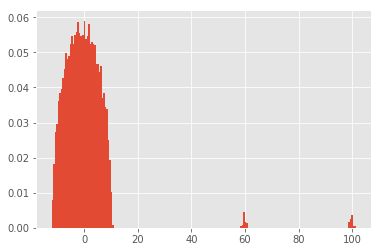

In [14]:
a, reps = [], 20
a = np.array([scipy.linalg.eigvalsh(planted_partition_graph(np.sum(nr), b, pin, pout)) for i in range(0,reps) ]).flatten()
plt.hist(a, density=True, bins=200)
plt.show()
plt.plot(allz,rho)
#plt.xlim([-100,100])

In [ ]:
plt.hist(a[a<60], density=True, bins=200)
plt.plot(allz/np.sqrt(b),np.sqrt(b)*rho)
plt.xlim([-50,50])

In [ ]:
n_=sp.Symbol('n',integer=True)
pin_=sp.Symbol('pin',real=True)
pout_=sp.Symbol('pout',real=True)
a_=sp.Symbol('a',real=True)
d_=sp.Symbol('d',real=True)
c_=sp.Symbol('c',integer=True)
z_=sp.Symbol('z',complex=True)
b_=sp.Symbol('b',integer=True)
t_=sp.Symbol('t',complex=True)

# this is the average degree in the planted partition model with B blocks and n nodes
def avg_deg_planted(n,b,pin,pout):
    return pin * n / b + (b-1) * pout * n / b

def poisspdf(k,l):
    return sp.exp(-l)*(l**k)/sp.gamma(k+1)

def adj_fundamental_eq(n,b,pin,pout,t,z):
    sum_sigma2rs_ns_ts = (n/b)*(pin*t_ + pout*t_)
    return  (t_ - sp.summation(sp.KroneckerDelta(c_,0)/(z_-c_-sum_sigma2rs_ns_ts),(c_,0,sp.oo)))

def adj_fundamental_eq_full(ns,b,sigma2rs,pin,pout,t,z):
    
    sum_sigma2rs_ns_ts = (n/b)*(pin*t_ + pout*t_)
    return  (t_ - sp.summation(sp.KroneckerDelta(c_,0)/(z_-c_-sum_sigma2rs_ns_ts),(c_,0,sp.oo)))

def adj_fundamental_eq2(a,d,t,z):
    return  (t_ - sp.summation(sp.KroneckerDelta(c_,d_)/(z_-c_-a*t_),(c_,0,sp.oo)))

def lapl_fundamental_eq(n,b,pin,pout,t,z):
    d = (n-1) / b * (pin+pout) # average within module degree
    sum_sigma2rs_ns_ts = (n/b)*(pin*t_ + pout*t_)
    return  (t_ - sp.summation(poisspdf(c_,d)/(z_-c_-sum_sigma2rs_ns_ts),(c_,0,sp.oo)))

def lapl_fundamental_eq2(a,d,t,z):   
    return  (t_ - sp.summation(poisspdf(c_,d)/(z_-c_-a*t_),(c_,0,sp.oo)))

adj_feq = sp.lambdify((n_,b_,pin_,pout_,t_,z_),adj_fundamental_eq(n_,b_,pin_,pout_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
adj_feq2 = sp.lambdify((a_,d_,t_,z_),adj_fundamental_eq2(a_,d_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
lapl_feq = sp.lambdify((n_,b_,pin_,pout_,t_,z_),lapl_fundamental_eq(n_,b_,pin_,pout_,t_,z_).replace('exp_polar','exp'), modules='mpmath')
#lapl_feq2 = sp.lambdify((a_,d_,t_,z_),lapl_fundamental_eq2(a_,d_,t_,z_).replace('exp_polar','exp'), modules='mpmath')

def Gamma(a, z0, z1):
    return mp.gammainc(a, z0) - mp.gammainc(a, z1)

def lapl_feq2(a,d,t,z): # Solution computed from Mathematica using a and d
    return t + ((-d)**(-(a*t) + z)*Gamma(a*t - z,0,-d))/mp.exp(d)

#### 2. Look for the spectrum of the adjacency matrix (planted partition n=50, B=2, pin=0.5,pout=0.5)

In [ ]:
def spectral_density(n,b,pin,pout,zmin,zmax,dz, matrix,**kwargs):
    # Solve Eq.2 given z, look for tr
    all_rho = []
    count = 0
    eps = kwargs.get('eps',1E-9)
    tr = [0]*b
    for r in range(0,b):
        # Now solve the equation for t and increasing z in iterative way
        z0 = zmin + eps*1j
        t0 = (np.random.random() + np.random.random()*1j) * 1E-3
        tr[r] = t0
        z = z0        
        nz = int((zmax-zmin)/dz)
        while np.real(z) < zmax:
            print('\r', count/(b*nz)*100.0,'%', '-- ',matrix, end='')
            if matrix is 'laplacian':
                tr[r] = mp.findroot(lambda t: lapl_feq(n,b,pin,pout,t,z), x0 = tr[r], solver='muller') # important to use the "muller" solver
            elif matrix is 'adjacency':
                tr[r] = mp.findroot(lambda t: adj_feq(n,b,pin,pout,t,z),  x0 = tr[r], solver='muller') # important to use the "muller" solver
            else:
                raise 'not supported matrix'
            z += dz
            rhoz = -1/(n*mp.pi)*(n/b*tr[r].imag)
            all_rho.append(rhoz)
            count += 1
    
    for z in np.linspace(zmin,zmax,nz):
        det = sp.ones(b)
        for r in range(0,b):
            det -= 
    # Solve Eq.4 
    ts1 = sp.Symbol('ts1',complex=True)
    ts2 = sp.Symbol('ts2',complex=True)
    det = sp.eye(b) - (sp.eye(b)*sp.diag([ts1,ts2])*sp.Matrix([[pin,pout],[pout,pin]])*sp.Matrix() )
    
    all_rho = np.array(all_rho).flatten()    
    return np.linspace(zmin,zmax,nz), np.reshape(all_rho,[b,nz]).sum(axis=0)

# This version takes a,d parameters
def spectral_density2(a,d,b,zmin,zmax,dz, matrix,**kwargs):
    # Solve Eq.2 given z, look for tr
    all_rho = []
    count = 0
    eps = kwargs.get('eps',1E-9)
    tr = [0]*b
    for r in range(0,b):
        # Now solve the equation for t and increasing z in iterative way
        z0 = zmin + eps*1j
        t0 = (np.random.random() + np.random.random()*1j) * 1E-3
        tr[r] = t0
        z = z0        
        nz = int((zmax-zmin)/dz)
        while np.real(z) < zmax:
            print('\r', count/(b*nz)*100.0,'%', '-- ',matrix, end='')
            if matrix is 'laplacian':
                tr[r] = mp.findroot(lambda t: lapl_feq2(a,d,t,z), x0 = tr[r], solver='muller') # important to use the "muller" solver
            elif matrix is 'adjacency':
                tr[r] = mp.findroot(lambda t: adj_feq2(a,d,t,z),  x0 = tr[r], solver='muller') # important to use the "muller" solver
            else:
                raise 'not supported matrix'
            z += dz
            rhoz = -1/(n*mp.pi)*np.array([n/b*tr[r].imag for r in range(0,b)]).sum()
            all_rho.append(rhoz)
            count += 1
    
    # Solve Eq.4 for t
    while np.real(z) < zmax:
        #det = lambda t: (sp.eye(b) - t*n/b*sp.Matrix([[pin,pout],[pout,pin]])).det()
        sp.eye(b) - 
        (mp.eye(b) - t*n/b*((mp.ones(b)-mp.eye(b))*pout + mp.eye(b)*pin)).det()
        mp.eigh(mp.matrix([[pin,pout],[pout,pin]]))
        zi = d + a*t + b/n*sp.eig
        
    all_rho = np.array(all_rho).flatten()
    
    return np.linspace(zmin,zmax,nz), np.reshape(all_rho,[b,nz]).sum(axis=0)

#### 3. Verify the results with the corresponding numerical simulation

In [ ]:
def planted_partition_graph(n,b,pin,pout):
    nb = int(n/b)
    A = (np.random.random((n,n)) < pout).astype(float)
    for i in range(0,b):
        T = np.triu((np.random.random((nb,nb))<pin).astype(float))
        T = T+T.T
        A[i*nb:(i+1)*nb,i*nb:(i+1)*nb] = T
        
    np.fill_diagonal(A,0)
    A = np.triu(A)
    A = A+A.T
    return A

In [ ]:
n, b, pin, pout = 2000, 2, 0.8, 0.8

eigs_l,eigs_a = [], []
for i in range(0,50):
    print('\r',i,end='')
    #A = nx.to_numpy_array(nx.planted_partition_graph(b,int(n/b),pin,pout),dtype=np.float128)
    A = planted_partition_graph(n,b,pin,pout)
    L=np.diag(A.sum(axis=0))-A
    eigs_a.append(scipy.linalg.eigvalsh(A))
    eigs_l.append(scipy.linalg.eigvalsh(L))
eigs_a = np.array(eigs_a).flatten()
eigs_l = np.array(eigs_l).flatten()

In [ ]:
dz=0.1
#all_z_adj,rho_adj  = spectral_density(n,b,pin,pout, -40,40, dz,'adjacency',eps=1E-9)
a = (eigs_a.min()/2)**2
print(a)
all_z_adj,rho_adj  = spectral_density2(a, 0, b, -60, 60, dz,'adjacency', eps=1E-9)
#all_z_lapl,rho_lapl  = spectral_density2(a,n*pin,b,3000, 3500,  50,'laplacian',eps=1E-9)

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,6))
ax[0].hist(eigs_a,2000,density=True,color='blue',alpha=0.4)
ax[0].plot(all_z_adj,rho_adj)
#ax[0].set_title('Adjacency n=%d B=%d $p_{in}$=%.2f $p_{out}$=%.2f' % (n,b,pin,pout),color='w')
ax[0].set_xlim([-70,70])
####
ax[1].hist(eigs_l,1000,density=True,color='blue',alpha=0.4)
#ax[1].plot(all_z_lapl, rho_lapl)
ax[1].set_xlim([1250,1750])
#ax[1].set_title('Laplacian n=%d B=%d $p_{in}$=%.2f $p_{out}$=%.2f' % (n,b,pin,pout),color='w')
#plt.subplots_adjust()
plt.show()

In [ ]:
plt.hist(eigs_l[np.logical_and(eigs_l<1600, eigs_l>100)] ,2000,density=True,color='blue',alpha=0.4)
plt.show()

In [ ]:
n, b, pin, pout = 100.0, 8, 1, 1
# Now solve the equation for t and increasing z in iterative way
t0 = (np.random.random() + np.random.random()*1j) * 1E-3
eps = 1E-9
z0 = -20 + eps*1j
zmax = 20
dz = 0.1

z = z0
t = t0

allt, allz = [], []
a = 10
d = 0
print(2*np.sqrt(a)-d)
while np.real(z) < zmax:
    print('\r',eps,(np.real(z)/zmax)*100,'%',end='')
    t = mp.findroot(lambda x: adj_feq2(a,d,x,z), x0 = t,solver='muller') # important to use the "muller" solver
    allz.append(z)
    z += dz
    allt.append(t)
allz = np.array([np.real(zz) for zz in allz])
allt = np.array([tt.imag for tt in allt])
plt.plot(allz,-1/(np.pi)*allt)
tmax = np.max(-1/(np.pi)*allt)
plt.vlines(-2*np.sqrt(a)+d,ymin=0,ymax=tmax)
plt.vlines(2*np.sqrt(a)+d, ymin=0,ymax=tmax)

In [ ]:
n, b, pin, pout = 500.0, 2, 0.8, 0.2
import networkx as nx
eigs_l,eigs_a = [], []
for i in range(0,100):
    A = nx.to_numpy_array(nx.planted_partition_graph(b,int(n/b),pin,pout))
    L=np.diag(A.sum(axis=0))-A
    #eigs_a.append(scipy.linalg.eigvalsh(A))
    eigs_l.append(scipy.linalg.eigvalsh(L))
eigs_a = np.array(eigs_a).flatten()
eigs_l = np.array(eigs_l).flatten()

In [ ]:
n, b, pin, pout = 500.0, 2, 0.8, 0.2
for count,a in enumerate(np.linspace(250,300,5)):
    # Now solve the equation for t and increasing z in iterative way
    t0 = (np.random.random() + np.random.random()*1j) * 1E-3
    eps = 1E-9
    z0 = 1000.0 + eps*1j
    zmax = 1800
    dz = 5

    z = z0
    t = t0

    allt, allz = [], []
    #a = 1
    d = n/b*(pin+pout)
    while np.real(z) < zmax:
        print('\r',count,eps,(np.real(z)/zmax)*100,'%',end='')
        t = mp.findroot(lambda x: lapl_feq2(a,d,x,z), x0 = t,solver='muller') # important to use the "muller" solver
        allz.append(z)
        z += dz
        allt.append(t)
    allz = np.array([np.real(zz) for zz in allz])
    allt = np.array([tt.imag for tt in allt])
    plt.figure()
    plt.plot(allz,np.abs(-1/(np.pi)*allt))
    plt.hist(eigs_l,400,density=True,color='blue',alpha=0.4)
    plt.title('a=%1.1f'%a)
plt.show()